In [1]:
# Import dependencies
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np
%matplotlib inline
from scipy.stats import norm
import statsmodels.api as sm
from datetime import datetime
import requests
from io import BytesIO
from statsmodels.tsa.statespace.sarimax import SARIMAXResults

# Importing Dependencies for DB connection
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import session
from sqlalchemy import create_engine, func
from sqlalchemy import inspect
from config import config
import psycopg2

In [2]:
# Establish a connection to the database
conn = psycopg2.connect(
    host = config['host'],
    port = config['port'], 
    dbname = config['dbname'], 
    user = config['user'], 
    password = config['password'])

print("Postgres Connected")

Postgres Connected


In [3]:
# Import Data from AWS database
data= pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
data

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
0,408280,2015-01-01,Quebec,101,"Total, all occupations","Type of work, all types",60505.0,None
1,408283,2015-01-01,Quebec,101,"Total, all occupations",Full-time,45385.0,None
2,653248,2015-01-01,Saskatchewan,101,"Total, all occupations","Type of work, all types",14230.0,None
3,653251,2015-01-01,Saskatchewan,101,"Total, all occupations",Full-time,10375.0,None
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
...,...,...,...,...,...,...,...,...
7225,27254351,2021-04-01,Nunavut,101,"Total, all occupations",Full-time,515.0,None
7226,27263181,2021-04-01,Nunavut,1,"Business, finance and administration occupations","Type of work, all types",75.0,None
7227,27263184,2021-04-01,Nunavut,1,"Business, finance and administration occupations",Full-time,70.0,None
7228,27309524,2021-04-01,Nunavut,7,"Trades, transport and equipment operators and ...","Type of work, all types",160.0,None


In [4]:
# slicing for 'Canada'
ts_data= data
ts_data= data.loc[data['geo']=='Canada',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,None
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,None
7,1143302,2015-04-01,Canada,0,Management occupations,"Type of work, all types",24100.0,None
8,1143305,2015-04-01,Canada,0,Management occupations,Full-time,23030.0,None


In [5]:
# slicing for 'Total, all occupations' in NOC
ts_data= ts_data.loc[ts_data['noc_desc']=='Total, all occupations',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
5,1143187,2015-04-01,Canada,101,"Total, all occupations",Full-time,322450.0,None
6,1143190,2015-04-01,Canada,101,"Total, all occupations",Part-time,129475.0,None
135,3429555,2015-10-01,Canada,101,"Total, all occupations",Full-time,230375.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None


In [6]:
# slicing for 'Total, all occupations' in job_char
ts_data= ts_data.loc[ts_data['job_char']=='Type of work, all types',:]

ts_data.head()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None
608,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,None
902,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,None
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,None


In [7]:
# remove Q3 2020- Q22021
df= ts_data
df = df.iloc[0:20]
df

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None
608,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,None
902,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,None
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,None
1527,6859104,2016-07-01,Canada,101,"Total, all occupations","Type of work, all types",404860.0,None
1840,8002288,2016-10-01,Canada,101,"Total, all occupations","Type of work, all types",381010.0,None
2154,9145472,2017-01-01,Canada,101,"Total, all occupations","Type of work, all types",387080.0,None
2468,10288656,2017-04-01,Canada,101,"Total, all occupations","Type of work, all types",459685.0,None
2787,11431840,2017-07-01,Canada,101,"Total, all occupations","Type of work, all types",467395.0,None


In [8]:

df=df.loc[:, ['ref_date','total_vacancies']]
df

,ref_date,total_vacancies
4,2015-04-01,451925.0
301,2015-07-01,407865.0
608,2015-10-01,358755.0
902,2016-01-01,330215.0
1203,2016-04-01,391190.0
1527,2016-07-01,404860.0
1840,2016-10-01,381010.0
2154,2017-01-01,387080.0
2468,2017-04-01,459685.0
2787,2017-07-01,467395.0


In [9]:
#check for null
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20 entries, 4 to 6006
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ref_date         20 non-null     object 
 1   total_vacancies  20 non-null     float64
dtypes: float64(1), object(1)
memory usage: 480.0+ bytes


In [10]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')
df.head()

,ref_date,total_vacancies
4,2015-04-01,451925.0
301,2015-07-01,407865.0
608,2015-10-01,358755.0
902,2016-01-01,330215.0
1203,2016-04-01,391190.0


In [11]:
df.set_index('ref_date', inplace=True)
df.shape

(20, 1)

## Time series Analysis 

In [12]:
#visualize the time series data

(array([16436., 16801., 17167., 17532., 17897., 18262.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

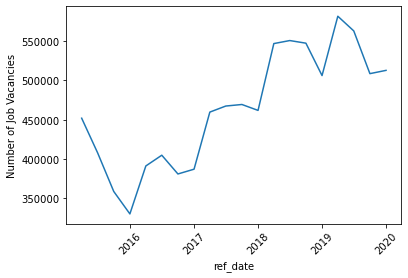

In [13]:
sns.lineplot(data= df, x='ref_date', y= 'total_vacancies')
plt.ylabel('Number of Job Vacancies')
plt.xticks(rotation=45)

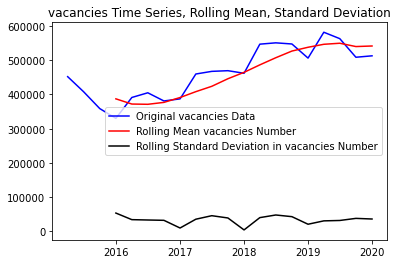

In [14]:
'''check for stationary
A stationary time series will not have any trends or seasonal patterns
We will use the Dickey Fuller test to check for stationarity in our data '''

rolling_mean = df.rolling(4).mean()
rolling_std = df.rolling(4).std()

#First, let’s make a Matplotlib plot of our time series
plt.plot(df, color="blue",label="Original vacancies Data")
# then the rolling mean
plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
#And finally, the rolling standard deviation:
plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
#Let’s then add a title:
plt.title("vacancies Time Series, Rolling Mean, Standard Deviation")
#And a legend:
plt.legend(loc="best")

In [15]:
#We will use the Dickey Fuller test to check for stationarity in our data
from statsmodels.tsa.stattools import adfuller
df_test=df.iloc[:,0].values
adft = adfuller(df_test,autolag="AIC")

output_df = pd.DataFrame({"Values":[adft[0],adft[1],adft[2],adft[3], adft[4]['1%'], adft[4]['5%'], adft[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
print(output_df)

      Values                       Metric
0  -1.354507              Test Statistics
1   0.603882                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)


our data is not stationary as p value is higher than 0.05

In [16]:
# Checking for autocorrelation in time series data
# This is a measure of how correlated time series data is at a given point in time with past values
autocorrelation_lag1 = df['total_vacancies'].autocorr(lag=1)
print("One Quarter Lag: ", autocorrelation_lag1)

autocorrelation_lag2 = df['total_vacancies'].autocorr(lag=2)
print("Two Quaretrs Lag: ", autocorrelation_lag2)

autocorrelation_lag3 = df['total_vacancies'].autocorr(lag=3)
print("Three Quaretrs Lag: ", autocorrelation_lag3)

autocorrelation_lag4 = df['total_vacancies'].autocorr(lag=4)
print("Four Quaretrs Lag: ", autocorrelation_lag4)

One Quarter Lag:  0.8417507442893579
Two Quaretrs Lag:  0.6965572514223229
Three Quaretrs Lag:  0.6788911778498717
Four Quaretrs Lag:  0.7749030868093133


the data is autocorrelated

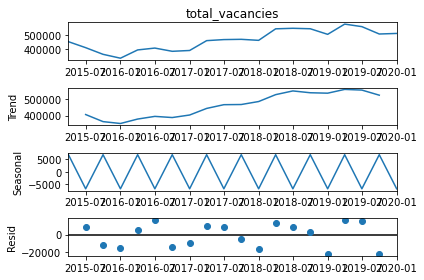

In [17]:
#Check for Trend decomposition is another useful way to visualize the trends in time series data
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(df['total_vacancies'],model='additive', period=2)
decompose.plot()
plt.show()

From this plot, we can clearly see the increasing trend in number of vacancies and the seasonality patterns in the rise and fall in values each year.

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.


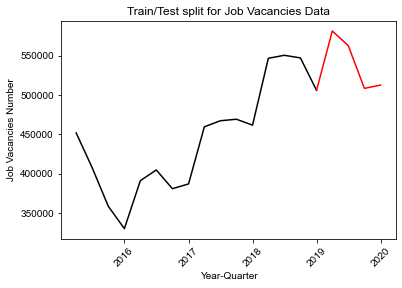

In [18]:
# Forescasting
df['ref_date']=df.index
train = df[df['ref_date'] < "2019-04-01"]
train['train'] = train['total_vacancies']
del train['ref_date']
del train['total_vacancies']

test = df[df['ref_date'] >= "2019-04-01"]
del test['ref_date']
test['test'] = test['total_vacancies']
del test['total_vacancies']

plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
sns.set()
plt.show()

In [19]:
# code to connect train and split data for the plot above
pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test])

,test
ref_date,
2019-01-01,506140.0
2019-04-01,581595.0
2019-07-01,562910.0
2019-10-01,508590.0
2020-01-01,512760.0


## SARIMAX

source: https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html

In [20]:
# Register converters to avoid warnings
pd.plotting.register_matplotlib_converters()
plt.rc("figure", figsize=(16,8))
plt.rc("font", size=14)

In [21]:
# Dataset
data = df
data.index = data.ref_date
# Set the frequency
data.index.freq="QS-OCT"

# Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
mod = sm.tsa.statespace.SARIMAX(train, trend='t', order=(1,0,1),seasonal_order=(1, 1, 1, 2))
res = mod.fit(disp=False)
print(res.summary())

                                     SARIMAX Results                                     
Dep. Variable:                             train   No. Observations:                   16
Model:             SARIMAX(1, 0, 1)x(1, 1, 1, 2)   Log Likelihood                -173.868
Date:                           Sat, 27 Nov 2021   AIC                            359.736
Time:                                   17:52:05   BIC                            363.571
Sample:                               04-01-2015   HQIC                           359.381
                                    - 01-01-2019                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -977.1508      0.000  -2.77e+06      0.000    -977.152    -977.150
ar.L1         -0.6853      0.079     -8.722

C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency QS-OCT will be used.
  % freq, ValueWarning)
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
C:\Users\wisam\anaconda3\envs\mlenv\lib\site-packages\statsmodels\base\model.

In [22]:
# forecast values for test data
forecast = res.predict(test.index[0],test.index[-1], dynamic=True)
forecast = pd.DataFrame(forecast.values,index = test.index,columns=['predicted_vacancies'])
forecast.head()

,predicted_vacancies
ref_date,
2019-04-01,587407.392035
2019-07-01,549985.454825
2019-10-01,535895.200785
2020-01-01,495415.010295


In [23]:
# create dataframe for results
output = test.merge(forecast, how='inner', left_index=True, right_index=True)
output.head()

,test,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295


In [24]:
#Evaluating SARIMA model

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,explained_variance_score,r2_score

evs = explained_variance_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Explained Variance Score : {evs}')
mse = mean_squared_error(output.test,output.predicted_vacancies, squared=False)
print(f'Mean Square Error : {mse}')
mape = mean_absolute_percentage_error(output.test,output.predicted_vacancies, multioutput='uniform_average')
print(f'Mean Absolute Percentage Error : {mape}')
rsqr =r2_score(output.test,output.predicted_vacancies,multioutput='uniform_average')
print(f'Coefficient of determination Training (R^2) : {rsqr}')

Explained Variance Score : 0.6867402095458842
Mean Square Error : 17658.216408647935
Mean Absolute Percentage Error : 0.030117219661569102
Coefficient of determination Training (R^2) : 0.6862300625673305


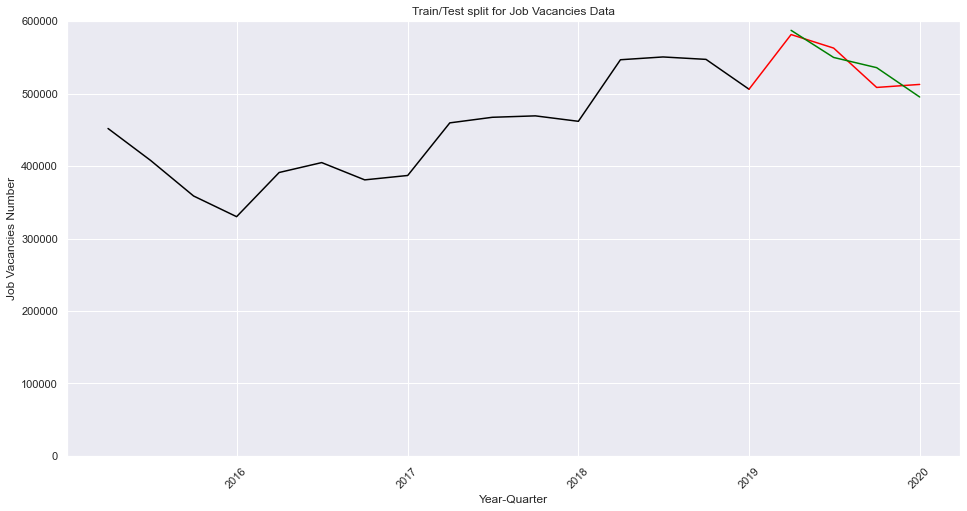

In [25]:
#visualize results
plt.plot(train, color = "black")
plt.plot(pd.concat([train.tail(1).rename({"train":"test"},axis='columns'),test]), color = "red")
plt.plot(forecast['predicted_vacancies'],color= 'green')
plt.title("Train/Test split for Job Vacancies Data")
plt.ylabel("Job Vacancies Number")
plt.xlabel('Year-Quarter')
plt.xticks(rotation=45)
plt.ylim(ymin=0)
sns.set()
plt.show()

In [26]:
# rename columns to prepare for later append
output.columns=['total_vacancies','predicted_vacancies']
output.head()

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295


In [27]:
# check model accuaracy with actual values from statCan
Actual=[560215,553480,731905]
predict_quarters=['2020-10-01','2021-01-01','2021-04-01']

forecast_data=[]
counter=0
for i in predict_quarters:
    forecast_test = res.predict(i)
    forecast_data.append(forecast_test)
    counter +=1
    
forecast_data

[2020-10-01    522737.441305
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481961.986259
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560978.298278
 Freq: QS-OCT, dtype: float64]

In [28]:
forecast_data[2].index # list of dataframes

DatetimeIndex(['2021-04-01'], dtype='datetime64[ns]', freq='QS-OCT')

In [29]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_data]

[522737, 481961, 560978]

In [30]:
# create results dataframe
forecast_df= pd.DataFrame({'Predicted Value':[int(f.values[0]) for f in forecast_data], 'Actual Value': Actual}, index=predict_quarters)
forecast_df.head()

,Predicted Value,Actual Value
2020-10-01,522737,560215
2021-01-01,481961,553480
2021-04-01,560978,731905


In [31]:
# generate predictions from Q2 2020-Q2 2025 for DB
actual_all = ['NAN','NAN',560215,\
              553480,731905,'NAN','NAN',\
             'NAN','NAN','NAN','NAN',\
              'NAN','NAN','NAN','NAN',\
              'NAN','NAN','NAN','NAN',\
              'NAN','NAN']
future_predictions= ['2020-04-01','2020-07-01','2020-10-01',\
                     '2021-01-01','2021-04-01','2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01']

forecast_all=[]

counter=0
for i in future_predictions:
    forecasts = res.predict(i)
    forecast_all.append(forecasts)
    counter +=1
    
forecast_all

[2020-04-01    575212.485279
 Freq: QS-OCT, dtype: float64,
 2020-07-01    537816.013763
 Freq: QS-OCT, dtype: float64,
 2020-10-01    522737.441305
 Freq: QS-OCT, dtype: float64,
 2021-01-01    481961.986259
 Freq: QS-OCT, dtype: float64,
 2021-04-01    560978.298278
 Freq: QS-OCT, dtype: float64,
 2021-07-01    523135.306389
 Freq: QS-OCT, dtype: float64,
 2021-10-01    507391.855414
 Freq: QS-OCT, dtype: float64,
 2022-01-01    466099.489547
 Freq: QS-OCT, dtype: float64,
 2022-04-01    544486.528351
 Freq: QS-OCT, dtype: float64,
 2022-07-01    506092.930312
 Freq: QS-OCT, dtype: float64,
 2022-10-01    489755.927449
 Freq: QS-OCT, dtype: float64,
 2023-01-01    447897.771692
 Freq: QS-OCT, dtype: float64,
 2023-04-01    525689.033803
 Freq: QS-OCT, dtype: float64,
 2023-07-01    486721.875884
 Freq: QS-OCT, dtype: float64,
 2023-10-01    469807.04991
 Freq: QS-OCT, dtype: float64,
 2024-01-01    427372.325071
 Freq: QS-OCT, dtype: float64,
 2024-04-01    504575.198075
 Freq: QS-OC

In [32]:
#keep only forecast numbers
[int(f.values[0]) for f in forecast_all]

[575212,
 537816,
 522737,
 481961,
 560978,
 523135,
 507391,
 466099,
 544486,
 506092,
 489755,
 447897,
 525689,
 486721,
 469807,
 427372,
 504575,
 465029,
 447540,
 404526,
 481142]

In [33]:
# create results dataframe
forecast_all_df= pd.DataFrame({'predicted_vacancies':[int(f.values[0]) for f in forecast_all], 'total_vacancies': actual_all}, index=future_predictions)
forecast_all_df= pd.DataFrame(forecast_all_df,columns=['total_vacancies','predicted_vacancies'])
forecast_all_df.head()                      

,total_vacancies,predicted_vacancies
2020-04-01,NAN,575212
2020-07-01,NAN,537816
2020-10-01,560215,522737
2021-01-01,553480,481961
2021-04-01,731905,560978


In [34]:
model_output = output.append(forecast_all_df)
model_output

,total_vacancies,predicted_vacancies
2019-04-01 00:00:00,581595.0,587407.392035
2019-07-01 00:00:00,562910.0,549985.454825
2019-10-01 00:00:00,508590.0,535895.200785
2020-01-01 00:00:00,512760.0,495415.010295
2020-04-01,NAN,575212.000000
2020-07-01,NAN,537816.000000
2020-10-01,560215,522737.000000
2021-01-01,553480,481961.000000
2021-04-01,731905,560978.000000
2021-07-01,NAN,523135.000000


In [35]:
ref_date= model_output.index.to_list()
ref_date[0]='2019-04-01'
ref_date[1]='2019-07-01'
ref_date[2]='2019-10-01'
ref_date[3]='2020-01-01'
ref_date

['2019-04-01',
 '2019-07-01',
 '2019-10-01',
 '2020-01-01',
 '2020-04-01',
 '2020-07-01',
 '2020-10-01',
 '2021-01-01',
 '2021-04-01',
 '2021-07-01',
 '2021-10-01',
 '2022-01-01',
 '2022-04-01',
 '2022-07-01',
 '2022-10-01',
 '2023-01-01',
 '2023-04-01',
 '2023-07-01',
 '2023-10-01',
 '2024-01-01',
 '2024-04-01',
 '2024-07-01',
 '2024-10-01',
 '2025-01-01',
 '2025-04-01']

In [36]:
model_output['ref_date']=ref_date
model_output.set_index('ref_date', inplace=True)
model_output.head(25)

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295
2020-04-01,NAN,575212.000000
2020-07-01,NAN,537816.000000
2020-10-01,560215,522737.000000
2021-01-01,553480,481961.000000
2021-04-01,731905,560978.000000


In [37]:
engine = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine.connect()
model_output.to_sql(name='TSmodel_output_Canada', con=conn, index=True)

In [38]:
output_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_Canada"', con=conn, index_col='ref_date')
output_test

,total_vacancies,predicted_vacancies
ref_date,,
2019-04-01,581595.0,587407.392035
2019-07-01,562910.0,549985.454825
2019-10-01,508590.0,535895.200785
2020-01-01,512760.0,495415.010295
2020-04-01,NAN,575212.000000
2020-07-01,NAN,537816.000000
2020-10-01,560215,522737.000000
2021-01-01,553480,481961.000000
2021-04-01,731905,560978.000000


In [39]:
conn

In [40]:
ts_data.tail()

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
5681,21529858,2019-10-01,Canada,101,"Total, all occupations","Type of work, all types",508590.0,None
6006,22649088,2020-01-01,Canada,101,"Total, all occupations","Type of work, all types",512760.0,None
6311,23821336,2020-10-01,Canada,101,"Total, all occupations","Type of work, all types",560215.0,None
6616,24993584,2021-01-01,Canada,101,"Total, all occupations","Type of work, all types",553480.0,None
6921,26165832,2021-04-01,Canada,101,"Total, all occupations","Type of work, all types",731905.0,None


In [41]:
# Function to apply timeseries model on province level
def province_vac (province):
    import warnings
    warnings.filterwarnings("ignore")
    
    # Import Data from AWS database
    df_prov = pd.read_sql_query('SELECT * FROM "machinelearning"', con=conn)
    #  convert the REF_DATE column into a datetime object
    df_prov['ref_date'] = pd.to_datetime(df_prov['ref_date'], format='%Y-%m')
    #select province data 
    prov_vac= df_prov.loc[df_prov['geo']== str(province),:] 
    # drop all unnecessary columns
    prov_vac = prov_vac.loc[:,['ref_date','total_vacancies']]
    # aggregate total vacancies per quarter
    prov_vac= prov_vac.groupby(prov_vac['ref_date']).sum()
    #remove Q32020 onwards
    prov_vac= prov_vac.loc['2015-04-01':'2020-01-01']
    # rename columns
    prov_vac.rename(columns={'total_vacancies':f'{province}_total_vacancies'}, inplace=True)
    #visualize the time series data
    sns.lineplot(data= prov_vac, x='ref_date', y= f'{province}_total_vacancies')
    plt.ylabel('Number of Job Vacancies')
    plt.xticks(rotation=45)
    
    #check for stationary using the Dickey Fuller test to check for stationarity in our data
    rolling_mean = prov_vac.rolling(4).mean()
    rolling_std = prov_vac.rolling(4).std()
    #First, make a Matplotlib plot of our time series
    plt.plot(prov_vac, color="blue",label="Original vacancies Data")
    # then the rolling mean
    plt.plot(rolling_mean, color="red", label="Rolling Mean vacancies Number")
    #And finally, the rolling standard deviation:
    plt.plot(rolling_std, color="black", label = "Rolling Standard Deviation in vacancies Number")
    #add a title:
    plt.title(f'{province} vacancies Time Series, Rolling Mean, Standard Deviation')
    #And a legend:
    plt.legend(loc="best")
    #use the Dickey Fuller test to check for stationarity in our data
    from statsmodels.tsa.stattools import adfuller
    prov_vac_test=prov_vac.iloc[:,0].values
    adft_prov = adfuller(prov_vac_test,autolag="AIC")
    output_prov_df = pd.DataFrame({"Values":[adft_prov[0],adft_prov[1],adft_prov[2],adft_prov[3], adft_prov[4]['1%'], adft_prov[4]['5%'], adft_prov[4]['10%']]  , "Metric":["Test Statistics","p-value","No. of lags used","Number of observations used", 
                                                        "critical value (1%)", "critical value (5%)", "critical value (10%)"]})
    print('Stationary Test Results')
    print(output_prov_df)
    
    # Checking for autocorrelation in time series data
    print('Autocorrelation Results')
    autocorrelation_lag1_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=1)
    print("One Quarter Lag: ", autocorrelation_lag1_prov)
    autocorrelation_lag2_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=2)
    print("Two Quaretrs Lag: ", autocorrelation_lag2_prov)
    autocorrelation_lag3_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=3)
    print("Three Quaretrs Lag: ", autocorrelation_lag3_prov)
    autocorrelation_lag4_prov = prov_vac[f'{province}_total_vacancies'].autocorr(lag=4)
    print("Four Quaretrs Lag: ", autocorrelation_lag4_prov)
    
    #Check for Trend decomposition to visualize the trends in time series data
    from statsmodels.tsa.seasonal import seasonal_decompose
    decompose_prov = seasonal_decompose(prov_vac[f'{province}_total_vacancies'],model='additive', period=2)
    decompose_prov.plot()
    print('Trend Decomposition Visualization')
    plt.show()
    
    # Forescasting
    prov_vac['ref_date']=prov_vac.index
    train_prov = prov_vac[prov_vac['ref_date'] < "2019-04-01"]
    train_prov[f'train_{province}'] = train_prov[f'{province}_total_vacancies']
    del train_prov['ref_date']
    del train_prov[f'{province}_total_vacancies']

    test_prov = prov_vac[prov_vac['ref_date'] >= "2019-04-01"]
    del test_prov['ref_date']
    test_prov[f'test_{province}'] = test_prov[f'{province}_total_vacancies']
    del test_prov[f'{province}_total_vacancies']

    # Register converters to avoid warnings
    pd.plotting.register_matplotlib_converters()
    plt.rc("figure", figsize=(16,8))
    plt.rc("font", size=14)
    
    # Dataset
    data_prov = prov_vac
    data_prov.index = data_prov.ref_date
    # Set the frequency
    data_prov.index.freq="QS-OCT"

    # Fit the model (configuration is set using previous autocorreleation, trend decomposition tests)
    mod_prov = sm.tsa.statespace.SARIMAX(train_prov, trend='t', order=(0,1,0),seasonal_order=(1, 1, 1, 2))
    res_prov = mod_prov.fit(disp=False)
    print(res_prov.summary())
    
    # produce forecast results
    forecast_prov = res_prov.predict(test_prov.index[0],test_prov.index[-1], dynamic=True)
    forecast_prov = pd.DataFrame(forecast_prov.values,index = test_prov.index,columns=[f'Prediction_{province}'])
    output_prov = test_prov.merge(forecast_prov, how='inner', left_index=True, right_index=True)
    print('Forecast Results')
    
    
    #plot results
    plt.plot(train_prov, color = "black")
    plt.plot(test_prov, color = "red")
    plt.plot(forecast_prov[f'Prediction_{province}'],color= 'green')
    plt.title(f"Train/Test/Forecast split for {province} Job Vacancies Data")
    plt.ylabel("Job Vacancies Number")
    plt.xlabel('Year-Quarter')
    plt.xticks(rotation=45)
    plt.ylim(ymin=0)
    sns.set()
    plt.show()
    
    from sklearn.metrics import mean_squared_error

    rms_prov = mean_squared_error(output_prov[f'test_{province}'],output_prov[f'Prediction_{province}'], squared=False)
                                  
    print(f'RMSE is {rms_prov}')
    
    res_prov.save(f'TSmodel_{province}.pkl')
    return output_prov
    
  

Stationary Test Results
      Values                       Metric
0  -1.423509              Test Statistics
1   0.570955                      p-value
2   0.000000             No. of lags used
3  19.000000  Number of observations used
4  -3.832603          critical value (1%)
5  -3.031227          critical value (5%)
6  -2.655520         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.7963399531408691
Two Quaretrs Lag:  0.7045189418650178
Three Quaretrs Lag:  0.6250813158211472
Four Quaretrs Lag:  0.7242079893406116
Trend Decomposition Visualization


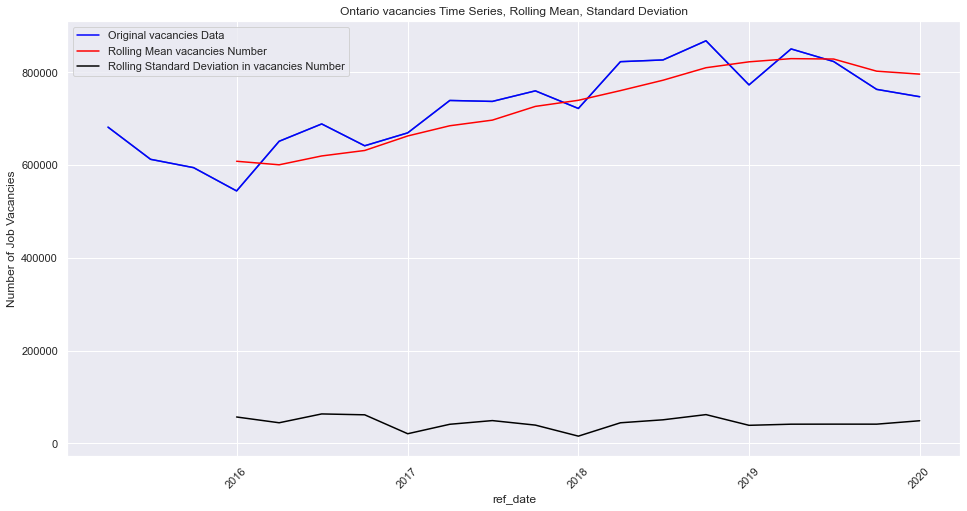

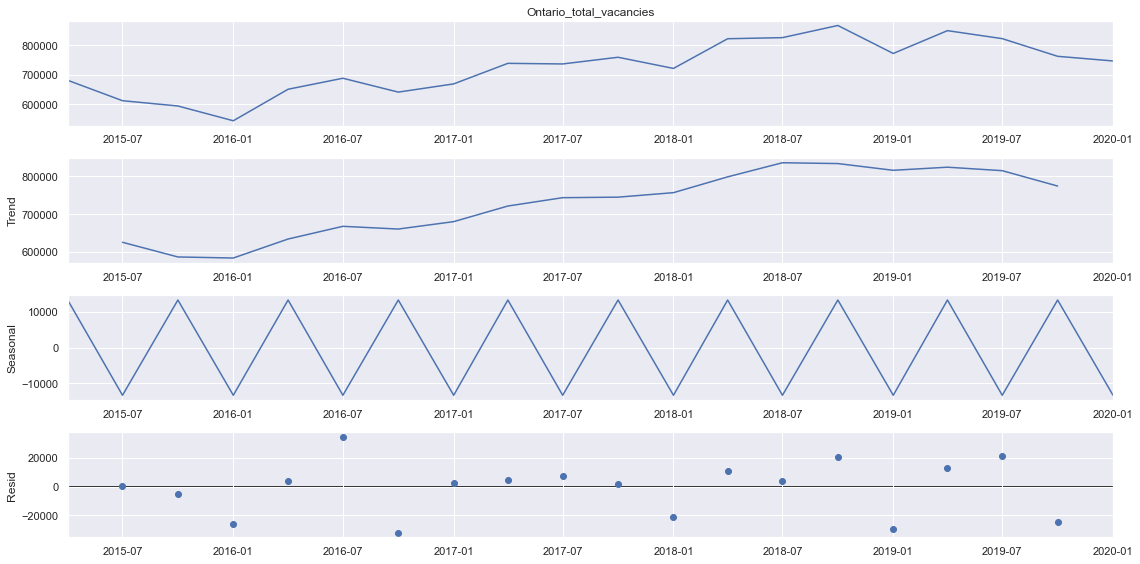

                                      SARIMAX Results                                      
Dep. Variable:                       train_Ontario   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -160.786
Date:                             Sat, 27 Nov 2021   AIC                            329.571
Time:                                     17:52:21   BIC                            331.831
Sample:                                 04-01-2015   HQIC                           329.107
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift      -1342.6312   6815.502     -0.197      0.844   -1.47e+04     1.2e+04
ar.S.L2       -0.8230      

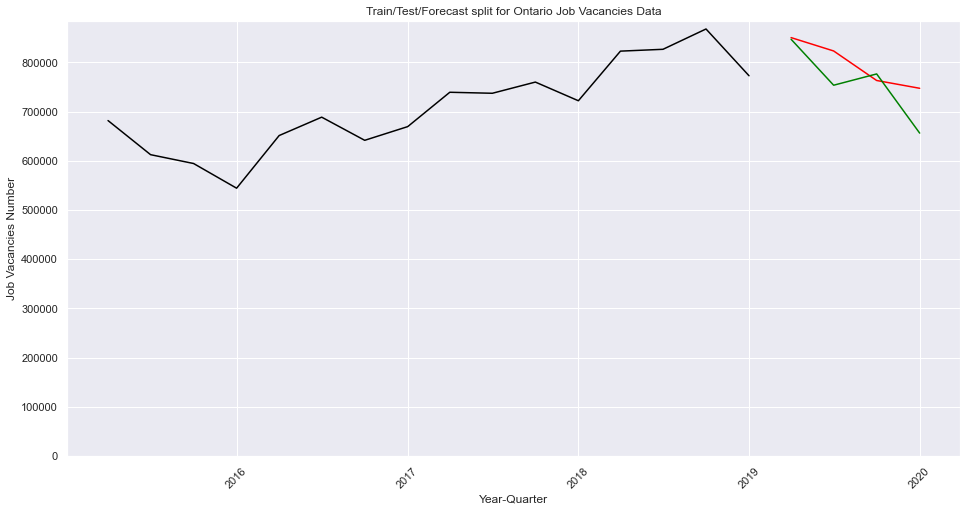

RMSE is 57750.909076977325
Stationary Test Results
      Values                       Metric
0  -1.813269              Test Statistics
1   0.373894                      p-value
2   4.000000             No. of lags used
3  15.000000  Number of observations used
4  -3.964443          critical value (1%)
5  -3.084908          critical value (5%)
6  -2.681814         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.9397928497976139
Two Quaretrs Lag:  0.8805409777015238
Three Quaretrs Lag:  0.8813156891310926
Four Quaretrs Lag:  0.9358048207068761
Trend Decomposition Visualization


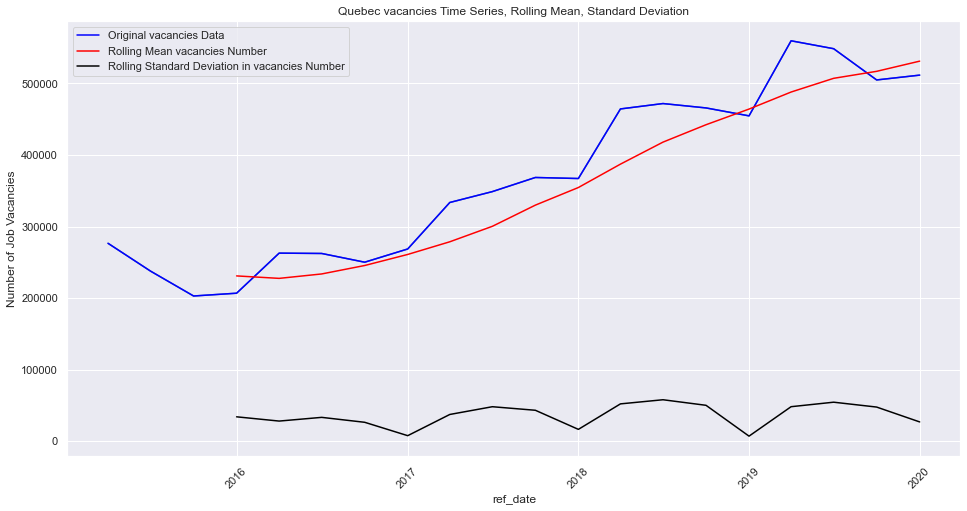

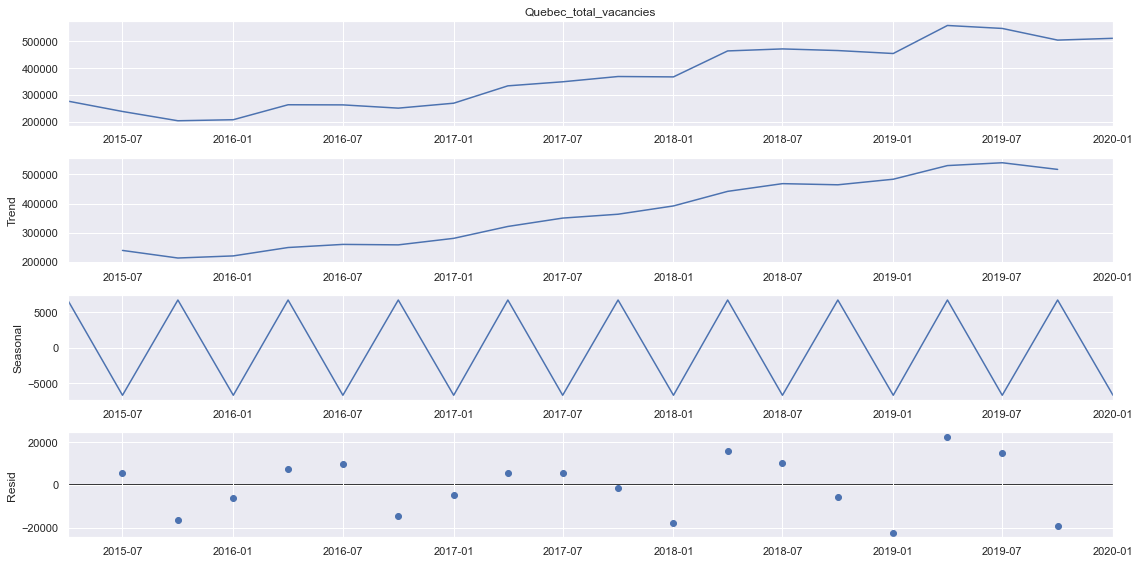

                                      SARIMAX Results                                      
Dep. Variable:                        train_Quebec   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -155.012
Date:                             Sat, 27 Nov 2021   AIC                            318.023
Time:                                     17:52:23   BIC                            320.283
Sample:                                 04-01-2015   HQIC                           317.559
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -789.8762   8068.705     -0.098      0.922   -1.66e+04     1.5e+04
ar.S.L2       -0.9408      

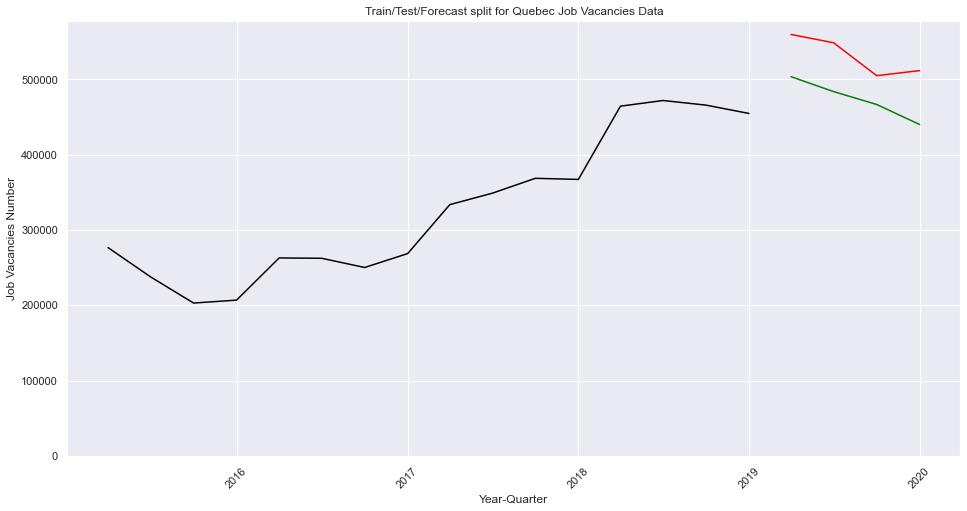

RMSE is 59022.88114936658
Stationary Test Results
      Values                       Metric
0  -0.249356              Test Statistics
1   0.932377                      p-value
2   6.000000             No. of lags used
3  13.000000  Number of observations used
4  -4.068854          critical value (1%)
5  -3.127149          critical value (5%)
6  -2.701730         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.8846193784527326
Two Quaretrs Lag:  0.7503522009857527
Three Quaretrs Lag:  0.7564710902767083
Four Quaretrs Lag:  0.7599747341282883
Trend Decomposition Visualization


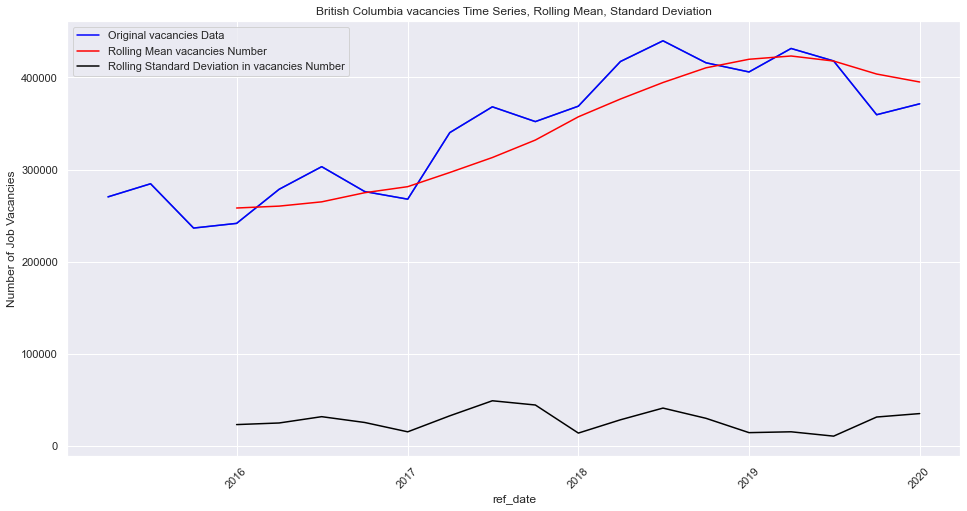

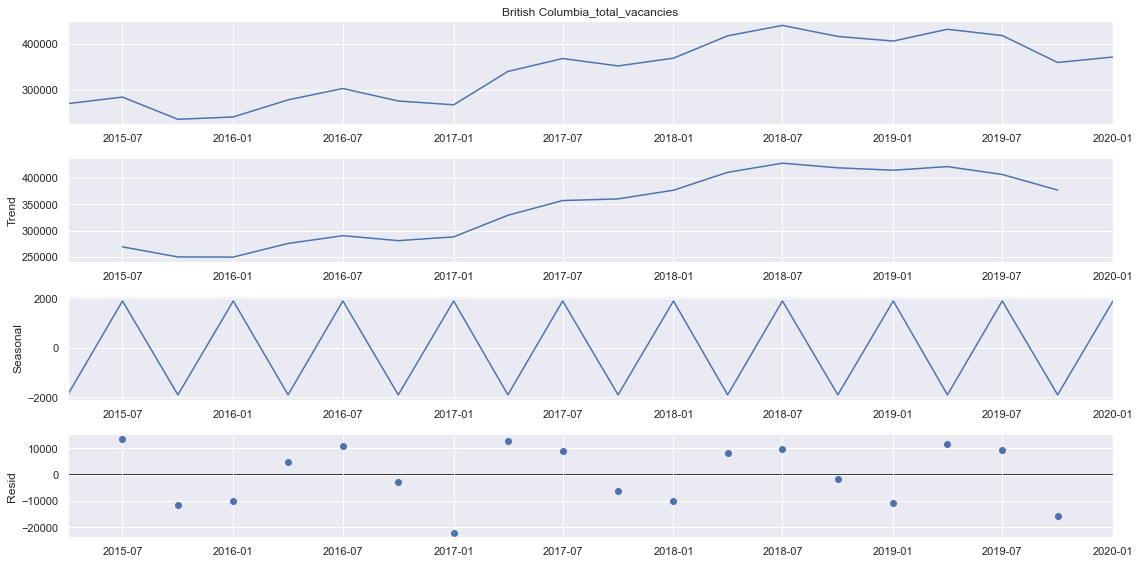

                                      SARIMAX Results                                      
Dep. Variable:              train_British Columbia   No. Observations:                   16
Model:             SARIMAX(0, 1, 0)x(1, 1, [1], 2)   Log Likelihood                -154.925
Date:                             Sat, 27 Nov 2021   AIC                            317.849
Time:                                     17:52:25   BIC                            320.109
Sample:                                 04-01-2015   HQIC                           317.385
                                      - 01-01-2019                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
drift       -904.5722    1.1e+04     -0.082      0.934   -2.24e+04    2.06e+04
ar.S.L2       -0.9294      

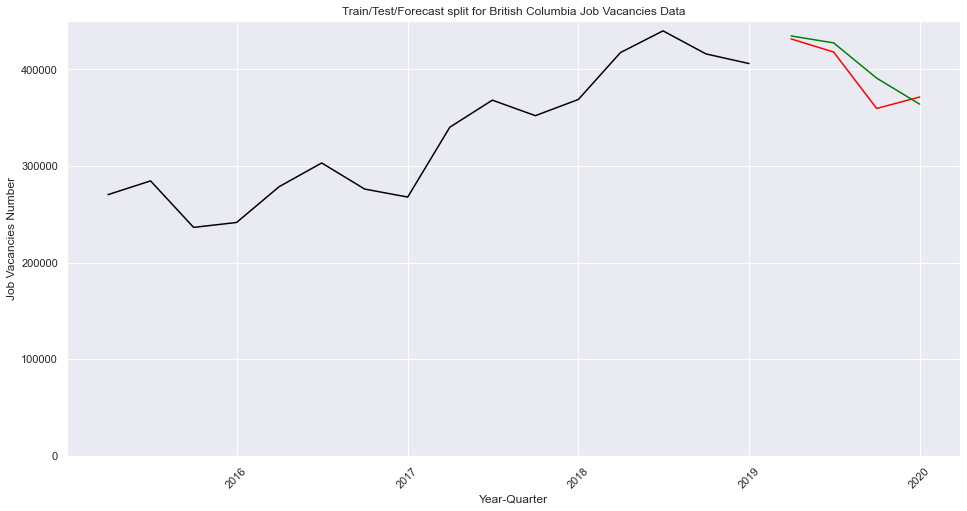

RMSE is 16875.622091629517
Stationary Test Results
      Values                       Metric
0  -1.144726              Test Statistics
1   0.696910                      p-value
2   7.000000             No. of lags used
3  12.000000  Number of observations used
4  -4.137829          critical value (1%)
5  -3.154972          critical value (5%)
6  -2.714477         critical value (10%)
Autocorrelation Results
One Quarter Lag:  0.6388271108589604
Two Quaretrs Lag:  0.08165832824352429
Three Quaretrs Lag:  -0.08905438650390443
Four Quaretrs Lag:  -0.05998627880919141


KeyboardInterrupt: 

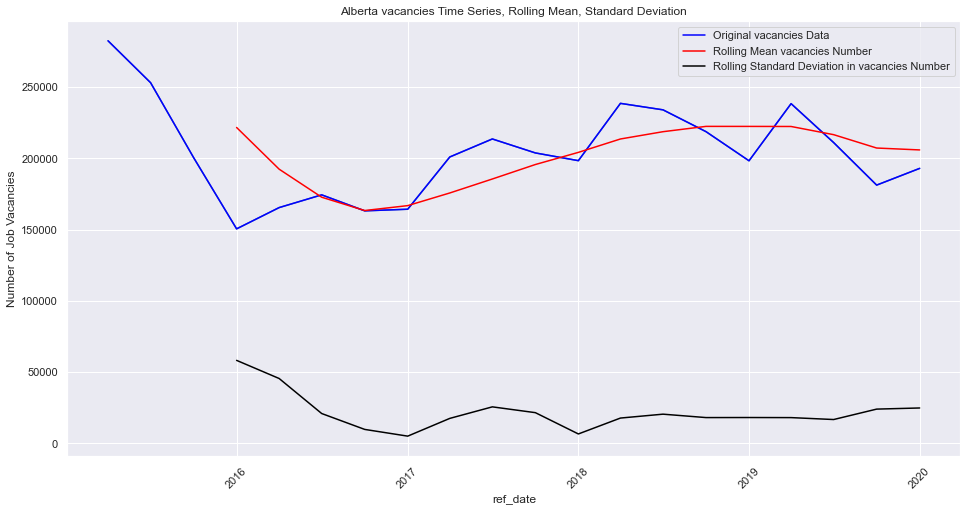

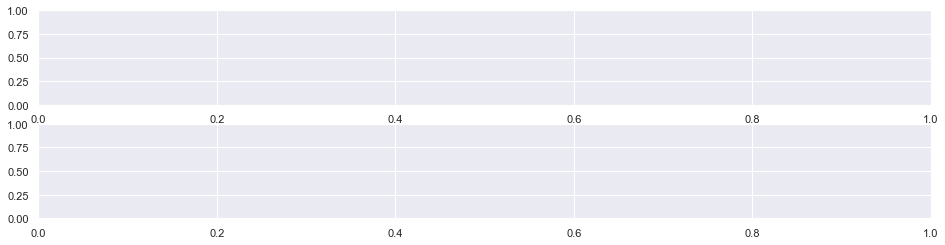

In [42]:
# produce all provinces prediction test results
provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

output_provencies= province_vac("Ontario")

for prov in provinces[1:13]:
    output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          
    
#output_provencies
print(output_provencies)

In [ ]:
output_provencies

In [ ]:
#make future predictions for all provinces

future_predictions= ['2020-04-01','2020-07-01','2020-10-01',\
                     '2021-01-01','2021-04-01','2021-07-01','2021-10-01',\
                     '2022-01-01','2022-04-01','2022-07-01','2022-10-01',\
                     '2023-01-01','2023-04-01','2023-07-01','2023-10-01',\
                    '2024-01-01','2024-04-01','2024-07-01','2024-10-01',\
                     '2025-01-01','2025-04-01']

provinces = ['Ontario', 'Quebec', 'British Columbia','Alberta',\
             'Manitoba', 'Saskatchewan','Nova Scotia', 'New Brunswick','Newfoundland and Labrador',\
             'Prince Edward Island', 'Yukon', 'Nunavut' ,'Northwest Territories']

#output_provencies= province_vac("Ontario")
prov_predictions={}
for prov in provinces[0:13]:
    #load province model
    loaded= SARIMAXResults.load(f'TSmodel_{prov}.pkl')
    #produce future forecast for each province
    
    
    res = []
    for q in future_predictions:
        res.append(loaded.predict(q))
    res_prov= pd.concat(res)
    prov_predictions[prov]= res_prov
    #print(prov_predictions)
    print(prov_predictions)
    
    #output_provencies = pd.merge(output_provencies , province_vac(prov), left_index=True, right_index=True)
          

In [ ]:
# produce all provinces prediction test results dataframe
prov_prediction_df= pd.DataFrame(prov_predictions)
prov_prediction_df.head(25)

In [ ]:
prov_prediction_df.to_csv("prov_prediction.csv")

In [44]:
# send df to sql DB
engine2 = create_engine(f"postgresql://{config['user']}:{config['password']}@{config['host']}:5432/{config['dbname']}")
conn=engine2.connect()
prov_prediction_df.to_sql(name='TSmodel_output_province', con=conn, index=True)

In [46]:
outputprov_test= pd.read_sql_query('SELECT * FROM "TSmodel_output_province"', con=conn)
outputprov_test

,index,Ontario,Quebec,British Columbia,Alberta,Manitoba,Saskatchewan,Nova Scotia,New Brunswick,Newfoundland and Labrador,Prince Edward Island,Yukon,Nunavut,Northwest Territories
0,2020-04-01,6.945140e+05,4.690417e+05,3.698634e+05,159865.667499,59455.494912,6537.676817,8.576759e+04,38048.747648,12562.707310,10991.131725,-738.436721,3123.567316,3573.844388
1,2020-07-01,5.681184e+05,4.322798e+05,3.422976e+05,130268.859123,51534.379598,-2147.224543,9.611804e+04,30799.356847,7212.313363,10985.291527,-2284.983195,3574.055566,4069.482012
2,2020-10-01,5.642418e+05,4.005500e+05,2.889217e+05,99370.447891,50111.481832,-11685.357126,1.142093e+05,27754.515920,5361.926588,8777.543957,-3431.894387,3881.538815,4489.344982
3,2021-01-01,4.119848e+05,3.551792e+05,2.411273e+05,59368.249391,42315.276225,-22677.054338,1.279921e+05,20857.148726,-1889.091553,6833.407387,-4949.589924,4544.231578,5083.174260
4,2021-04-01,4.105754e+05,3.617123e+05,2.211185e+05,56826.058480,51095.271383,-34609.346642,1.634513e+05,31257.420176,-449.639008,12118.853790,-5288.502507,5025.569623,5612.110785
5,2021-07-01,2.460362e+05,3.046937e+05,1.695096e+05,15109.778928,42282.802958,-48102.181548,1.858347e+05,23228.769263,-7952.618290,12095.669819,-7280.068136,5696.518207,6316.545210
6,2021-10-01,2.076879e+05,2.546927e+05,9.497166e+04,-26665.416313,40048.624101,-62634.827706,2.167852e+05,19389.211397,-11922.339954,9869.886021,-8889.743833,6220.564637,6962.477275
7,2022-01-01,1.700574e+04,1.873055e+05,2.248440e+04,-79336.713857,31276.531670,-78830.547014,2.436859e+05,11648.427349,-21457.340893,7907.018724,-10888.096029,7061.377761,7787.653998
8,2022-04-01,-2.853604e+04,1.683747e+05,-2.670390e+04,-96668.750577,38930.064859,-96167.296535,2.924131e+05,21158.345557,-22503.128975,13173.039374,-11725.522881,7736.703399,8559.448858
9,2022-07-01,-2.366393e+05,8.783587e+04,-1.060201e+05,-152394.442708,29082.426027,-115268.898231,3.287680e+05,12225.608164,-32499.193310,13129.736669,-14233.313596,8642.674006,9514.861434


In [45]:
loaded= SARIMAXResults.load('TSmodel_Alberta.pkl')

In [49]:
res = []
for q in future_predictions:
    res.append(loaded.predict(q))
pd.concat(res)

2020-04-01    159865.667499
2020-07-01    130268.859123
2020-10-01     99370.447891
2021-01-01     59368.249391
2021-04-01     56826.058480
2021-07-01     15109.778928
2021-10-01    -26665.416313
2022-01-01    -79336.713857
2022-04-01    -96668.750577
2022-07-01   -152394.442708
2022-10-01   -207084.667094
2023-01-01   -274349.868751
2023-04-01   -308254.791767
2023-07-01   -379881.375124
2023-10-01   -449513.621065
2024-01-01   -533296.062444
2024-04-01   -585567.668803
2024-07-01   -674988.026700
2024-10-01   -761579.004333
2025-01-01   -863800.678313
2025-04-01   -936242.593959
Freq: QS-OCT, dtype: float64

## Re-trian SARIMAX model with all data available

In [43]:
ts_data

,id,ref_date,geo,noc_code,noc_desc,job_char,total_vacancies,predicted_vacancies
4,1143184,2015-04-01,Canada,101,"Total, all occupations","Type of work, all types",451925.0,None
301,2286368,2015-07-01,Canada,101,"Total, all occupations","Type of work, all types",407865.0,None
608,3429552,2015-10-01,Canada,101,"Total, all occupations","Type of work, all types",358755.0,None
902,4572736,2016-01-01,Canada,101,"Total, all occupations","Type of work, all types",330215.0,None
1203,5715920,2016-04-01,Canada,101,"Total, all occupations","Type of work, all types",391190.0,None
1527,6859104,2016-07-01,Canada,101,"Total, all occupations","Type of work, all types",404860.0,None
1840,8002288,2016-10-01,Canada,101,"Total, all occupations","Type of work, all types",381010.0,None
2154,9145472,2017-01-01,Canada,101,"Total, all occupations","Type of work, all types",387080.0,None
2468,10288656,2017-04-01,Canada,101,"Total, all occupations","Type of work, all types",459685.0,None
2787,11431840,2017-07-01,Canada,101,"Total, all occupations","Type of work, all types",467395.0,None


In [81]:
# remove unnecessary columns
df= ts_data
df=df.loc[:, ['ref_date','total_vacancies']]
df

,ref_date,total_vacancies
4,2015-04-01,451925.0
301,2015-07-01,407865.0
608,2015-10-01,358755.0
902,2016-01-01,330215.0
1203,2016-04-01,391190.0
1527,2016-07-01,404860.0
1840,2016-10-01,381010.0
2154,2017-01-01,387080.0
2468,2017-04-01,459685.0
2787,2017-07-01,467395.0


In [82]:
# impute missing data for Q2 & Q3 2020
df.loc[-1] = ['2020-04-01', 544151.77] # adding Q2 2020 row
df.loc[-2] = ['2020-07-01', 531932.19] # adding Q3 2020 row
#df.index = df.index -2  # shifting index
#df = df.sort_index()  # sorting by index

In [83]:
#  convert the REF_DATE column into a datetime object
df['ref_date'] = pd.to_datetime(df['ref_date'], format='%Y-%m')
df.head()

df.sort_values(by='ref_date')

,ref_date,total_vacancies
4,2015-04-01,451925.00
301,2015-07-01,407865.00
608,2015-10-01,358755.00
902,2016-01-01,330215.00
1203,2016-04-01,391190.00
1527,2016-07-01,404860.00
1840,2016-10-01,381010.00
2154,2017-01-01,387080.00
2468,2017-04-01,459685.00
2787,2017-07-01,467395.00


In [84]:
# set ref_date as index
df = df.set_index('ref_date')

In [86]:
df.sort_index()

,total_vacancies
ref_date,
2015-04-01,451925.00
2015-07-01,407865.00
2015-10-01,358755.00
2016-01-01,330215.00
2016-04-01,391190.00
2016-07-01,404860.00
2016-10-01,381010.00
2017-01-01,387080.00
2017-04-01,459685.00


In [61]:
# close connection to DB
conn.close()